In [1]:
!python -m pip install xgboost

  Using cached xgboost-2.1.1-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.1-py3-none-manylinux_2_28_x86_64.whl (153.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 1.6 MB/s eta 0:00:000m eta 0:00:010:01:01


In [12]:
!python -m pip install hyperopt

  Using cached hyperopt-0.2.7-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
Using cached future-1.0.0-py3-none-any.whl (491 kB)
Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm
from utils import LoadRumoursDataset,LoadRumoursDatasetFilterNode
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pylab as plt
import uuid
from tqdm import tqdm
import xgboost as xgb
from sklearn.metrics import *

In [4]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
#mlflow.set_experiment("spyder-experiment")
import mlflow.pytorch
mlflow.set_experiment("Xgb experiment 2024-09-24")

2024/09/25 01:14:56 INFO mlflow.tracking.fluent: Experiment with name 'Xgb experiment 2024-09-24' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/azureuser/rumour-detection-pheme/mlruns/21', creation_time=1727226896857, experiment_id='21', last_update_time=1727226896857, lifecycle_stage='active', name='Xgb experiment 2024-09-24', tags={}>

In [5]:
#
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"


In [9]:
time_cut =1e10
processor = LoadRumoursDataset(file_path_replies, file_path_posts, time_cut)
processor.load_data()
processor.process_data()
df_final = processor.get_final_dataframe()
df_final['id'] = [uuid.uuid4() for _ in range(len(df_final))]


In [14]:
df_final.groupby('rumour').count()

,followers,favorite_count,retweet_count,embeddings_avg,replies,first_time_diff,no_verified,verified,id
rumour,,,,,,,,,
0,1555,1555,1555,1555,1555,1555,1555,1555,1555
1,447,447,447,447,447,447,447,447,447


In [17]:
df_final

,followers,favorite_count,retweet_count,rumour,embeddings_avg,replies,first_time_diff,no_verified,verified,id
0,-0.073004,-0.532290,-0.160000,1,"[-0.12270056130364537, 0.01583862374536693, -0...",5,3.510619,1,0,456b1289-fc10-4192-871e-579b8c01aa1f
1,0.031065,-0.344423,1.293333,1,"[-0.12335950043052435, -0.055849663292368255, ...",5,0.999077,0,1,4981be73-2565-417b-b931-ec7fc3e56458
2,0.356672,-0.524462,-0.302222,1,"[-0.1364929385483265, -0.07159566258390744, -0...",5,0.740536,0,1,441fbaff-5f96-4fd9-a2f1-1d007357674c
3,0.332156,-0.524462,-0.400000,1,"[-0.045377860377941816, -0.20127306692302227, ...",3,-0.164358,0,1,8f52bc5f-7f54-44d7-b44e-96cb1b49f96a
4,1.046022,-0.391389,0.964444,1,"[-0.03706469060853124, -0.1309182441327721, -0...",10,-0.352724,0,1,6b5fed78-77bb-4213-a752-681a9b8627aa
...,...,...,...,...,...,...,...,...,...,...
1997,3.895910,-0.140900,-0.124444,0,"[0.21622000262141228, -0.15450449846684933, -0...",8,0.204986,0,1,ff1db5ff-c2dd-4c47-8d51-efe94cc9a67d
1998,10.452911,3.859100,5.213333,0,"[0.21485890651291067, 0.03315381561829285, -0....",9,-0.245614,0,1,98658bc0-2379-40db-8ed7-97101b83442e
1999,0.012322,1.189824,0.955556,0,"[0.08846200071275234, -0.1485882457345724, 0.1...",9,0.500462,1,0,eb581d69-e6fc-4303-9464-104df528c008
2000,3.631498,0.477495,1.075556,0,"[0.021962551607025996, -0.019428667094972398, ...",18,-0.271468,0,1,b904ad73-b441-4ba1-b79c-6735d90bf177


In [10]:
df_not_rumours = df_final[df_final.rumour==0]

#n = int((df_final.rumour.sum())*1) // df_not_rumours['replies'].nunique()  # Unique number of values in 'replies' column

# Group by 'replies' and sample 'n' rows from each group
subset_df_not_rumours= df_not_rumours.sample(n= int(df_final[df_final.rumour==1].shape[0]*1.2))

#subset_df_not_rumours= df_not_rumours.groupby('replies',group_keys=False).apply(lambda x: x.sample(n=min(len(x), n))).reset_index(drop=True)


In [8]:
df_final_balanced =pd.concat([subset_df_not_rumours,df_final[df_final.rumour==1]])

In [8]:
df_final_remaining = df_final[(~df_final.id.isin(subset_df_not_rumours.id))&(df_final.rumour==0)]

In [9]:
X  = df_final_balanced.drop(columns=['rumour','id'])
X = np.hstack([X.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X.embeddings_avg.tolist()))])
y =df_final_balanced['rumour']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y,shuffle=True
)

In [10]:
X_test_all  = df_final_remaining.drop(columns=['rumour','id'])
X_test_all = np.hstack([X_test_all.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X_test_all.embeddings_avg.tolist()))])
y_test_all =df_final_remaining['rumour']
X_test_all = np.concatenate((X_test_all, X_test), axis=0)
y_test_all = pd.concat([y_test_all, y_test], axis=0)

In [11]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Define the hyperparameter distributions
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200)
}

# Create the XGBoost model object
xgb_model = xgb.XGBClassifier()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='recall')

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.04634731817110998, 'max_depth': 7, 'n_estimators': 114, 'subsample': 0.9335825616239708}
Best score:  0.8405320813771517


In [33]:
# Define the search space
from hyperopt import hp
from hyperopt.pyll.base import scope
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

space = {
    'max_depth': hp.choice("max_depth", np.arange(1,20,1,dtype=int)),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.3),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 200, 10)),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-3), np.log(10)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-3), np.log(10)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
}

# Objective function to minimize
def objective(params):
    xgb_model = xgb.XGBClassifier(
        eval_metric='error',
        **params
    )
    
    # Cross-validation
    skf = StratifiedKFold(n_splits=5)
    score = cross_val_score(xgb_model, X_train, y_train, cv=skf, scoring=make_scorer(recall_score)).mean()
    
    return {'loss': -score, 'status': STATUS_OK}

# Run Hyperopt
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42)
)

# Print the best hyperparameters
print("Best hyperparameters:", best)

# Convert hyperopt output to correct types
best_params = {
    'max_depth': int(best['max_depth']),
    'learning_rate': best['learning_rate'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'n_estimators': int(best['n_estimators']),
    'gamma': best['gamma'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda'],
    'min_child_weight': int(best['min_child_weight']),
}

# Train the final model with the best hyperparameters
final_model = xgb.XGBClassifier(
    eval_metric='error',
    **best_params
)
final_model.fit(X_train, y_train)

# Output the final model and best parameters
print("Final model:", final_model)
print("Best parameters:", best_params)

100%|█████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10trial/s, best loss: -0.8405320813771517]
Best hyperparameters: {'colsample_bytree': 0.9171402656256009, 'gamma': 2.69311430760292, 'learning_rate': 0.2223951887873663, 'max_depth': 0, 'min_child_weight': 9.0, 'n_estimators': 60.0, 'reg_alpha': 4.880582226571204, 'reg_lambda': 0.15097743936563188, 'subsample': 0.7113495836349794}
Final model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04634731817110998,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
         

In [34]:
best_params

{'max_depth': 0,
 'learning_rate': 0.2223951887873663,
 'subsample': 0.7113495836349794,
 'colsample_bytree': 0.9171402656256009,
 'n_estimators': 60,
 'gamma': 2.69311430760292,
 'reg_alpha': 4.880582226571204,
 'reg_lambda': 0.15097743936563188,
 'min_child_weight': 9}

In [20]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

def modelfit(alg, X_train, y_train, X_test, y_test, performCV=True, printFeatureImportance=True, cv_folds=5):
    # Fit the algorithm on the data
    alg.fit(X_train, y_train)
        
    # Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]

    # Predict test set:
    dtest_predictions = alg.predict(X_test)
    dtest_predprob = alg.predict_proba(X_test)[:,1]
    
    # Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='recall')
    
    # Print model report for Train:
    print("\nModel Report Train")
    print("AUC Score : %f" % roc_auc_score(y_train, dtrain_predprob))
    print("Accuracy : %.4g" % accuracy_score(y_train, dtrain_predictions))
    print("Precision : %.4g" % precision_score(y_train, dtrain_predictions))
    print("Recall : %f" % recall_score(y_train, dtrain_predictions))
    
    # Plot confusion matrix for Train
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_train, dtrain_predictions), annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Train")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    # Print model report for Test:
    print("\nModel Report Test")
    print("AUC Score : %f" % roc_auc_score(y_test, dtest_predprob))
    print("Accuracy : %.4g" % accuracy_score(y_test, dtest_predictions))
    print("Precision : %.4g" % precision_score(y_test, dtest_predictions))
    print("Recall : %f" % recall_score(y_test, dtest_predictions))
    
    # Plot confusion matrix for Test
    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y_test, dtest_predictions), annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Test")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    plt.tight_layout()
    plt.show()
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))

    return alg



In [21]:
# Train the final model with the best hyperparameters
final_model = xgb.XGBClassifier(
    eval_metric='logloss',
    **best_params
)
final_model.fit(X_train, y_train)

# Output the final model and best parameters
print("Final model:", final_model)
print("Best parameters:", best_params)

Final model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9171402656256009, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=2.69311430760292,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2223951887873663,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=60, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Best parameters: {'max_depth': 0, 'learning_rate': 0.2223951887873663, 'subsample': 0.7113495836349794, 'colsample_bytree': 0.9171402656256009, 'n_estimators': 60, 'gamma': 2.693


Model Report Train
AUC Score : 0.968123
Accuracy : 0.8995
Precision : 0.8819
Recall : 0.899160

Model Report Test
AUC Score : 0.889616
Accuracy : 0.8274
Precision : 0.8111
Recall : 0.811111


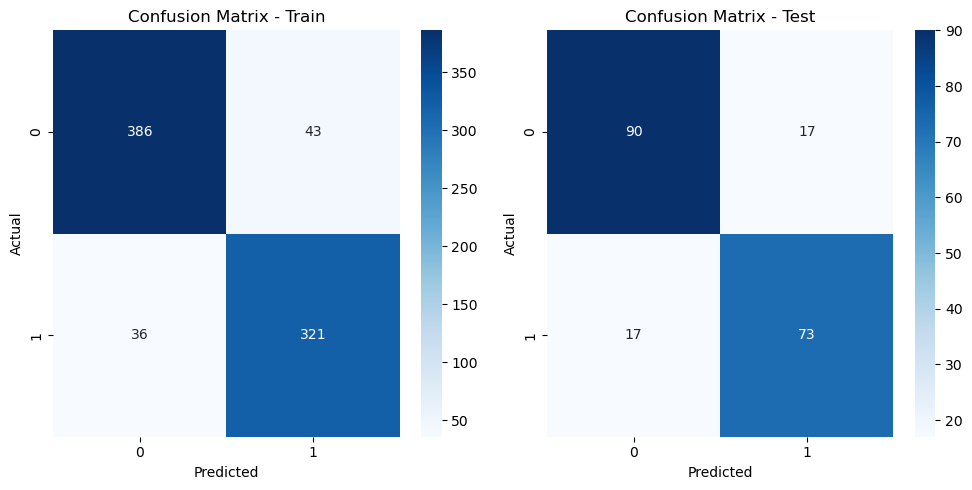

CV Score : Mean - 0.8180751 | Std - 0.03096333 | Min - 0.7638889 | Max - 0.8591549


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9171402656256009, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=2.69311430760292,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2223951887873663,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=60, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
modelfit(final_model, X_train, y_train,X_test,y_test)


Model Report Train
AUC Score : 0.968123
Accuracy : 0.8995
Precision : 0.8819
Recall : 0.899160

Model Report Test
AUC Score : 0.887641
Accuracy : 0.8281
Precision : 0.2755
Recall : 0.811111


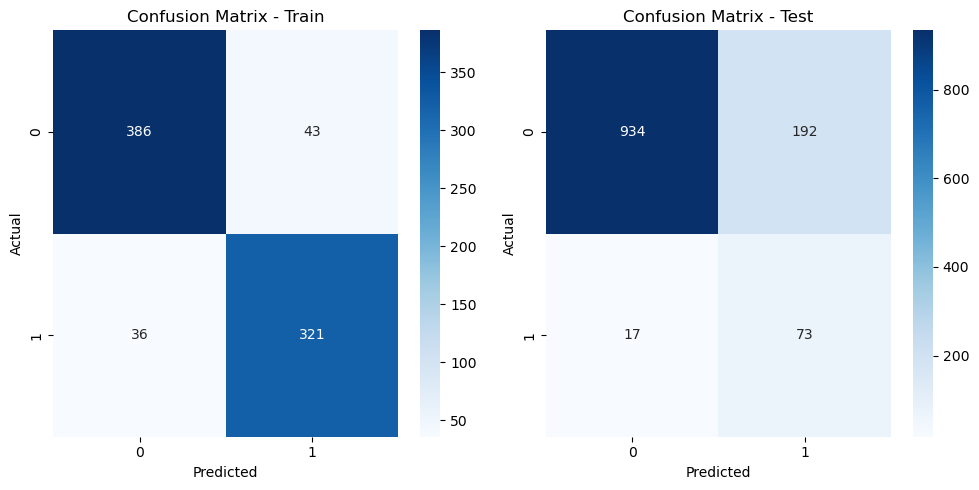

CV Score : Mean - 0.8180751 | Std - 0.03096333 | Min - 0.7638889 | Max - 0.8591549


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9171402656256009, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=2.69311430760292,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2223951887873663,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=60, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [23]:
modelfit(final_model, X_train, y_train,X_test_all,y_test_all)

In [27]:
best_params

{'max_depth': 0,
 'learning_rate': 0.2223951887873663,
 'subsample': 0.7113495836349794,
 'colsample_bytree': 0.9171402656256009,
 'n_estimators': 60,
 'gamma': 2.69311430760292,
 'reg_alpha': 4.880582226571204,
 'reg_lambda': 0.15097743936563188,
 'min_child_weight': 9}

In [30]:
# Train the final model with the best hyperparameters
params = {'learning_rate': 0.04634731817110998, 'max_depth': 7, 'n_estimators': 114, 'subsample': 0.9335825616239708}
final_model = xgb.XGBClassifier(**params)

final_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04634731817110998,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=114, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


Model Report Train
AUC Score : 1.000000
Accuracy : 1
Precision : 1
Recall : 1.000000

Model Report Test
AUC Score : 0.897404
Accuracy : 0.8426
Precision : 0.8242
Recall : 0.833333


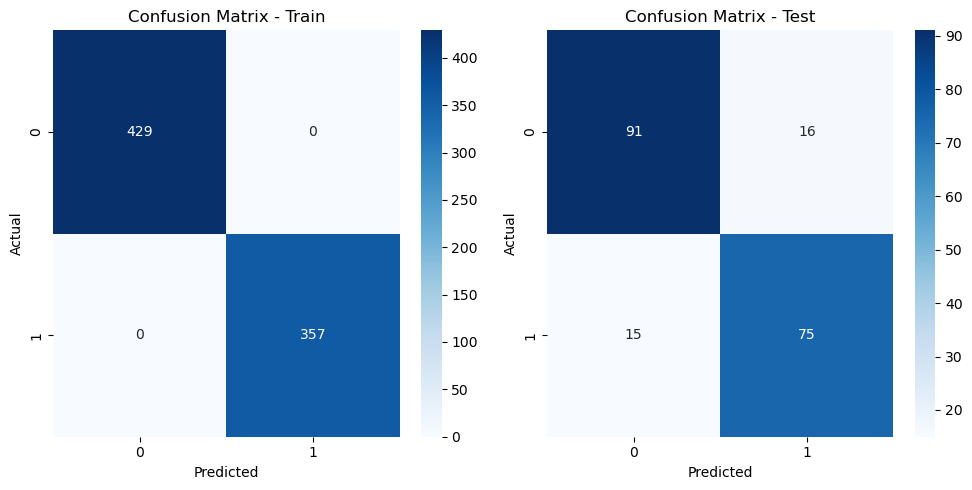

CV Score : Mean - 0.8405321 | Std - 0.04409259 | Min - 0.7777778 | Max - 0.915493


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04634731817110998,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=114, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [31]:
modelfit(final_model, X_train, y_train,X_test,y_test)


Model Report Train
AUC Score : 1.000000
Accuracy : 1
Precision : 1
Recall : 1.000000

Model Report Test
AUC Score : 0.900794
Accuracy : 0.8306
Precision : 0.282
Recall : 0.833333


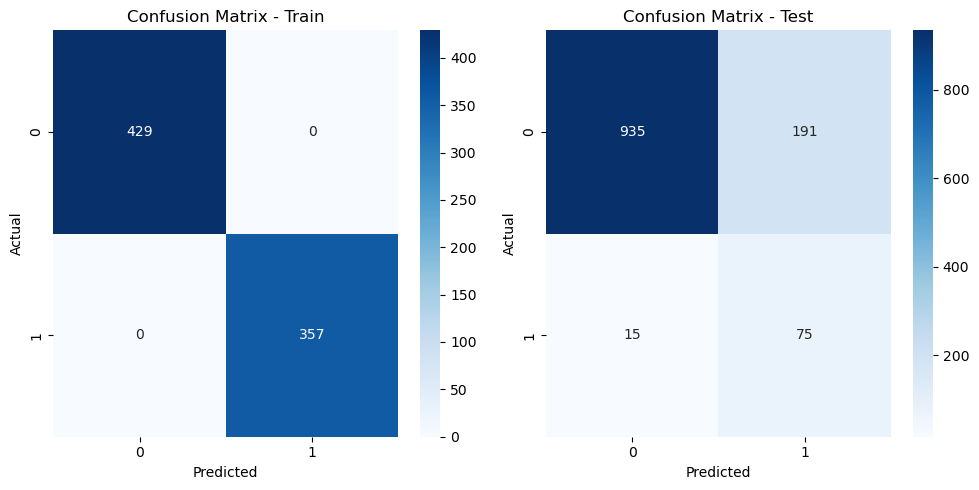

CV Score : Mean - 0.8405321 | Std - 0.04409259 | Min - 0.7777778 | Max - 0.915493


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04634731817110998,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=114, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [32]:
modelfit(final_model, X_train, y_train,X_test_all,y_test_all)

In [39]:
def modelfit(alg, X_train, y_train, X_test, y_test, printFeatureImportance=True):
    with mlflow.start_run():
        # Fit the algorithm on the data
        alg.fit(X_train, y_train)
            
        # Predict training set:
        dtrain_predictions = alg.predict(X_train)
        dtrain_predprob = alg.predict_proba(X_train)[:, 1]

        # Predict test set:
        dtest_predictions = alg.predict(X_test)
        dtest_predprob = alg.predict_proba(X_test)[:, 1]

        # Log model parameters
        mlflow.log_params(alg.get_params())

        # Log metrics for Train
        mlflow.log_metric("train_auc", roc_auc_score(y_train, dtrain_predprob))
        mlflow.log_metric("train_accuracy", accuracy_score(y_train, dtrain_predictions))
        mlflow.log_metric("train_precision", precision_score(y_train, dtrain_predictions))
        mlflow.log_metric("train_recall", recall_score(y_train, dtrain_predictions))

        # Log metrics for Test
        mlflow.log_metric("test_auc", roc_auc_score(y_test, dtest_predprob))
        mlflow.log_metric("test_accuracy", accuracy_score(y_test, dtest_predictions))
        mlflow.log_metric("test_precision", precision_score(y_test, dtest_predictions))
        mlflow.log_metric("test_recall", recall_score(y_test, dtest_predictions))

        # Print model report for Train
        print("\nModel Report Train")
        print("AUC Score : %f" % roc_auc_score(y_train, dtrain_predprob))
        print("Accuracy : %.4g" % accuracy_score(y_train, dtrain_predictions))
        print("Precision : %.4g" % precision_score(y_train, dtrain_predictions))
        print("Recall : %f" % recall_score(y_train, dtrain_predictions))

        # Plot confusion matrix for Train
        
        #plt.figure(figsize=(10, 5))
        #plt.subplot(1, 2, 1)
        #sns.heatmap(confusion_matrix(y_train, dtrain_predictions), annot=True, fmt="d", cmap="Blues")
        #plt.title("Confusion Matrix - Train")
        #plt.xlabel("Predicted")
        #plt.ylabel("Actual")

        # Log confusion matrix for Train
        train_cm = confusion_matrix(y_train, dtrain_predictions)
        mlflow.log_artifact(plot_confusion_matrix(train_cm, "Train"))

        # Print model report for Test
        print("\nModel Report Test")
        print("AUC Score : %f" % roc_auc_score(y_test, dtest_predprob))
        print("Accuracy : %.4g" % accuracy_score(y_test, dtest_predictions))
        print("Precision : %.4g" % precision_score(y_test, dtest_predictions))
        print("Recall : %f" % recall_score(y_test, dtest_predictions))

        # Plot confusion matrix for Test
        #plt.subplot(1, 2, 2)
        #sns.heatmap(confusion_matrix(y_test, dtest_predictions), annot=True, fmt="d", cmap="Blues")
        #plt.title("Confusion Matrix - Test")
        #plt.xlabel("Predicted")
        #plt.ylabel("Actual")

        # Log confusion matrix for Test
        test_cm = confusion_matrix(y_test, dtest_predictions)
        mlflow.log_artifact(plot_confusion_matrix(test_cm, "Test"))

        plt.tight_layout()
        plt.show()

        # Log the model with input example
        input_example = X_train[0:1]   # Use the first row of X_train as an example
        mlflow.sklearn.log_model(alg, "model", input_example=input_example)
        mlflow.log_metric("time_cut", time_cut)
    
    # Explicitly end the MLflow run
    mlflow.end_run()

    return alg

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"confusion_matrix_{title}.png")
    plt.close()
    return f"confusion_matrix_{title}.png"

In [41]:
#
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"

for time_cut in range(5,48*60,15):
    print(time_cut)
    processor = LoadRumoursDataset(file_path_replies, file_path_posts, time_cut)
    processor.load_data()
    processor.process_data()
    df_final = processor.get_final_dataframe()
    df_final['id'] = [uuid.uuid4() for _ in range(len(df_final))]
    df_not_rumours = df_final[df_final.rumour==0]

    n =  df_final[df_final.rumour==1].shape[0]  # Unique number of values in 'replies' column

    # Group by 'replies' and sample 'n' rows from each group
    subset_df_not_rumours= df_not_rumours.sample(n= n)
    df_final_balanced =pd.concat([subset_df_not_rumours,df_final[df_final.rumour==1]])
    df_final_remaining = df_final[(~df_final.id.isin(subset_df_not_rumours.id))&(df_final.rumour==0)]

    X  = df_final_balanced.drop(columns=['rumour','id'])
    X = np.hstack([X.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X.embeddings_avg.tolist()))])
    y =df_final_balanced['rumour']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42,stratify=y,shuffle=True
    )

    X_test_all  = df_final_remaining.drop(columns=['rumour','id'])
    X_test_all = np.hstack([X_test_all.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X_test_all.embeddings_avg.tolist()))])
    y_test_all =df_final_remaining['rumour']
    X_test_all = np.concatenate((X_test_all, X_test), axis=0)
    y_test_all = pd.concat([y_test_all, y_test], axis=0)
    
    final_model = xgb.XGBClassifier(eval_metric='logloss',**best_params)
    
    modelfit(final_model,  X_train, y_train,X_test_all,y_test_all)

5

Model Report Train
AUC Score : 0.966160
Accuracy : 0.8979
Precision : 0.876
Recall : 0.927374

Model Report Test
AUC Score : 0.894450
Accuracy : 0.8104
Precision : 0.2508
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

/home/azureuser/miniconda3/envs/mastering/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


20

Model Report Train
AUC Score : 0.963366
Accuracy : 0.8853
Precision : 0.871
Recall : 0.905028

Model Report Test
AUC Score : 0.897470
Accuracy : 0.8252
Precision : 0.2687
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

35

Model Report Train
AUC Score : 0.960088
Accuracy : 0.9035
Precision : 0.8833
Recall : 0.930168

Model Report Test
AUC Score : 0.915055
Accuracy : 0.8081
Precision : 0.2516
Recall : 0.898876


<Figure size 640x480 with 0 Axes>

50

Model Report Train
AUC Score : 0.962560
Accuracy : 0.8993
Precision : 0.8803
Recall : 0.924581

Model Report Test
AUC Score : 0.896569
Accuracy : 0.8073
Precision : 0.2427
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

65

Model Report Train
AUC Score : 0.958852
Accuracy : 0.8881
Precision : 0.8639
Recall : 0.921788

Model Report Test
AUC Score : 0.896560
Accuracy : 0.7972
Precision : 0.2362
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

80

Model Report Train
AUC Score : 0.958554
Accuracy : 0.9021
Precision : 0.8892
Recall : 0.918994

Model Report Test
AUC Score : 0.900152
Accuracy : 0.8135
Precision : 0.2508
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

95

Model Report Train
AUC Score : 0.968765
Accuracy : 0.9021
Precision : 0.881
Recall : 0.930168

Model Report Test
AUC Score : 0.890904
Accuracy : 0.8174
Precision : 0.255
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

110

Model Report Train
AUC Score : 0.958144
Accuracy : 0.8881
Precision : 0.8737
Recall : 0.907821

Model Report Test
AUC Score : 0.905639
Accuracy : 0.8337
Precision : 0.2744
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

125

Model Report Train
AUC Score : 0.961027
Accuracy : 0.8951
Precision : 0.8794
Recall : 0.916201

Model Report Test
AUC Score : 0.902562
Accuracy : 0.8221
Precision : 0.2603
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

140

Model Report Train
AUC Score : 0.967916
Accuracy : 0.8979
Precision : 0.8841
Recall : 0.916201

Model Report Test
AUC Score : 0.903078
Accuracy : 0.8197
Precision : 0.2593
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

155

Model Report Train
AUC Score : 0.963081
Accuracy : 0.8923
Precision : 0.8808
Recall : 0.907821

Model Report Test
AUC Score : 0.899289
Accuracy : 0.8174
Precision : 0.2517
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

170

Model Report Train
AUC Score : 0.970839
Accuracy : 0.8993
Precision : 0.8824
Recall : 0.921788

Model Report Test
AUC Score : 0.891101
Accuracy : 0.819
Precision : 0.2568
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

185

Model Report Train
AUC Score : 0.964337
Accuracy : 0.9021
Precision : 0.8892
Recall : 0.918994

Model Report Test
AUC Score : 0.902928
Accuracy : 0.8159
Precision : 0.2517
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

200

Model Report Train
AUC Score : 0.952780
Accuracy : 0.8965
Precision : 0.8777
Recall : 0.921788

Model Report Test
AUC Score : 0.902741
Accuracy : 0.8011
Precision : 0.2332
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

215

Model Report Train
AUC Score : 0.958140
Accuracy : 0.8811
Precision : 0.8509
Recall : 0.924581

Model Report Test
AUC Score : 0.897282
Accuracy : 0.8096
Precision : 0.2417
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

230

Model Report Train
AUC Score : 0.949486
Accuracy : 0.8811
Precision : 0.8621
Recall : 0.907821

Model Report Test
AUC Score : 0.912757
Accuracy : 0.8446
Precision : 0.289
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

245

Model Report Train
AUC Score : 0.966179
Accuracy : 0.8979
Precision : 0.88
Recall : 0.921788

Model Report Test
AUC Score : 0.895838
Accuracy : 0.8143
Precision : 0.2533
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

260

Model Report Train
AUC Score : 0.969305
Accuracy : 0.9091
Precision : 0.8949
Recall : 0.927374

Model Report Test
AUC Score : 0.894806
Accuracy : 0.805
Precision : 0.2437
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

275

Model Report Train
AUC Score : 0.961089
Accuracy : 0.8937
Precision : 0.8852
Recall : 0.905028

Model Report Test
AUC Score : 0.903200
Accuracy : 0.8228
Precision : 0.2578
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

290

Model Report Train
AUC Score : 0.964884
Accuracy : 0.8993
Precision : 0.8824
Recall : 0.921788

Model Report Test
AUC Score : 0.893990
Accuracy : 0.8112
Precision : 0.2416
Recall : 0.808989


<Figure size 640x480 with 0 Axes>

305

Model Report Train
AUC Score : 0.966383
Accuracy : 0.9133
Precision : 0.9044
Recall : 0.924581

Model Report Test
AUC Score : 0.895256
Accuracy : 0.8089
Precision : 0.2476
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

320

Model Report Train
AUC Score : 0.961504
Accuracy : 0.8979
Precision : 0.8862
Recall : 0.913408

Model Report Test
AUC Score : 0.900133
Accuracy : 0.8174
Precision : 0.2583
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

335

Model Report Train
AUC Score : 0.961434
Accuracy : 0.8839
Precision : 0.8706
Recall : 0.902235

Model Report Test
AUC Score : 0.896485
Accuracy : 0.8306
Precision : 0.2655
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

350

Model Report Train
AUC Score : 0.963128
Accuracy : 0.8965
Precision : 0.8838
Recall : 0.913408

Model Report Test
AUC Score : 0.904710
Accuracy : 0.8197
Precision : 0.2609
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

365

Model Report Train
AUC Score : 0.961469
Accuracy : 0.9049
Precision : 0.8898
Recall : 0.924581

Model Report Test
AUC Score : 0.900302
Accuracy : 0.8026
Precision : 0.2397
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

380

Model Report Train
AUC Score : 0.964657
Accuracy : 0.8993
Precision : 0.8865
Recall : 0.916201

Model Report Test
AUC Score : 0.895753
Accuracy : 0.8104
Precision : 0.2442
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

395

Model Report Train
AUC Score : 0.965498
Accuracy : 0.9091
Precision : 0.897
Recall : 0.924581

Model Report Test
AUC Score : 0.905489
Accuracy : 0.8205
Precision : 0.2585
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

410

Model Report Train
AUC Score : 0.964955
Accuracy : 0.9077
Precision : 0.8967
Recall : 0.921788

Model Report Test
AUC Score : 0.899749
Accuracy : 0.819
Precision : 0.25
Recall : 0.808989


<Figure size 640x480 with 0 Axes>

425

Model Report Train
AUC Score : 0.959325
Accuracy : 0.8839
Precision : 0.8647
Recall : 0.910615

Model Report Test
AUC Score : 0.907186
Accuracy : 0.8314
Precision : 0.2681
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

440

Model Report Train
AUC Score : 0.961942
Accuracy : 0.8951
Precision : 0.8753
Recall : 0.921788

Model Report Test
AUC Score : 0.902806
Accuracy : 0.812
Precision : 0.2524
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

455

Model Report Train
AUC Score : 0.963437
Accuracy : 0.9105
Precision : 0.893
Recall : 0.932961

Model Report Test
AUC Score : 0.887012
Accuracy : 0.8065
Precision : 0.2333
Recall : 0.786517


<Figure size 640x480 with 0 Axes>

470

Model Report Train
AUC Score : 0.957072
Accuracy : 0.8909
Precision : 0.8723
Recall : 0.916201

Model Report Test
AUC Score : 0.899983
Accuracy : 0.8306
Precision : 0.2705
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

485

Model Report Train
AUC Score : 0.963445
Accuracy : 0.9077
Precision : 0.8925
Recall : 0.927374

Model Report Test
AUC Score : 0.901146
Accuracy : 0.8135
Precision : 0.2541
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

500

Model Report Train
AUC Score : 0.960194
Accuracy : 0.8853
Precision : 0.8791
Recall : 0.893855

Model Report Test
AUC Score : 0.897019
Accuracy : 0.8213
Precision : 0.2594
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

515

Model Report Train
AUC Score : 0.963484
Accuracy : 0.9021
Precision : 0.885
Recall : 0.924581

Model Report Test
AUC Score : 0.901643
Accuracy : 0.8298
Precision : 0.2679
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

530

Model Report Train
AUC Score : 0.963460
Accuracy : 0.8979
Precision : 0.8841
Recall : 0.916201

Model Report Test
AUC Score : 0.898342
Accuracy : 0.819
Precision : 0.26
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

545

Model Report Train
AUC Score : 0.970307
Accuracy : 0.9133
Precision : 0.9
Recall : 0.930168

Model Report Test
AUC Score : 0.890520
Accuracy : 0.7964
Precision : 0.2387
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

560

Model Report Train
AUC Score : 0.966214
Accuracy : 0.9161
Precision : 0.9027
Recall : 0.932961

Model Report Test
AUC Score : 0.900752
Accuracy : 0.791
Precision : 0.2305
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

575

Model Report Train
AUC Score : 0.961395
Accuracy : 0.8965
Precision : 0.8797
Recall : 0.918994

Model Report Test
AUC Score : 0.906914
Accuracy : 0.8174
Precision : 0.2599
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

590

Model Report Train
AUC Score : 0.962118
Accuracy : 0.8895
Precision : 0.876
Recall : 0.907821

Model Report Test
AUC Score : 0.903603
Accuracy : 0.8166
Precision : 0.259
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

605

Model Report Train
AUC Score : 0.959908
Accuracy : 0.8909
Precision : 0.8684
Recall : 0.921788

Model Report Test
AUC Score : 0.894253
Accuracy : 0.8151
Precision : 0.2475
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

620

Model Report Train
AUC Score : 0.960530
Accuracy : 0.8881
Precision : 0.8717
Recall : 0.910615

Model Report Test
AUC Score : 0.902984
Accuracy : 0.8182
Precision : 0.2607
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

635

Model Report Train
AUC Score : 0.959364
Accuracy : 0.8937
Precision : 0.877
Recall : 0.916201

Model Report Test
AUC Score : 0.898098
Accuracy : 0.8252
Precision : 0.2589
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

650

Model Report Train
AUC Score : 0.954771
Accuracy : 0.9063
Precision : 0.8819
Recall : 0.938547

Model Report Test
AUC Score : 0.892292
Accuracy : 0.8011
Precision : 0.2431
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

665

Model Report Train
AUC Score : 0.968037
Accuracy : 0.8993
Precision : 0.8824
Recall : 0.921788

Model Report Test
AUC Score : 0.912673
Accuracy : 0.8151
Precision : 0.2557
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

680

Model Report Train
AUC Score : 0.963934
Accuracy : 0.8951
Precision : 0.8794
Recall : 0.916201

Model Report Test
AUC Score : 0.909662
Accuracy : 0.8291
Precision : 0.2669
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

695

Model Report Train
AUC Score : 0.959055
Accuracy : 0.8965
Precision : 0.8859
Recall : 0.910615

Model Report Test
AUC Score : 0.895547
Accuracy : 0.8166
Precision : 0.2558
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

710

Model Report Train
AUC Score : 0.965573
Accuracy : 0.9035
Precision : 0.8895
Recall : 0.921788

Model Report Test
AUC Score : 0.900311
Accuracy : 0.819
Precision : 0.2568
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

725

Model Report Train
AUC Score : 0.959728
Accuracy : 0.9049
Precision : 0.8919
Recall : 0.921788

Model Report Test
AUC Score : 0.907796
Accuracy : 0.8159
Precision : 0.2517
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

740

Model Report Train
AUC Score : 0.957694
Accuracy : 0.8825
Precision : 0.8683
Recall : 0.902235

Model Report Test
AUC Score : 0.908555
Accuracy : 0.8469
Precision : 0.2907
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

755

Model Report Train
AUC Score : 0.960996
Accuracy : 0.8951
Precision : 0.8835
Recall : 0.910615

Model Report Test
AUC Score : 0.910731
Accuracy : 0.8221
Precision : 0.2586
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

770

Model Report Train
AUC Score : 0.964243
Accuracy : 0.9049
Precision : 0.8877
Recall : 0.927374

Model Report Test
AUC Score : 0.890679
Accuracy : 0.8166
Precision : 0.2457
Recall : 0.797753


<Figure size 640x480 with 0 Axes>

785

Model Report Train
AUC Score : 0.964767
Accuracy : 0.9021
Precision : 0.883
Recall : 0.927374

Model Report Test
AUC Score : 0.910441
Accuracy : 0.8228
Precision : 0.2676
Recall : 0.898876


<Figure size 640x480 with 0 Axes>

800

Model Report Train
AUC Score : 0.965393
Accuracy : 0.8993
Precision : 0.8865
Recall : 0.916201

Model Report Test
AUC Score : 0.902900
Accuracy : 0.8104
Precision : 0.2459
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

815

Model Report Train
AUC Score : 0.967169
Accuracy : 0.9021
Precision : 0.875
Recall : 0.938547

Model Report Test
AUC Score : 0.905057
Accuracy : 0.8174
Precision : 0.2599
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

830

Model Report Train
AUC Score : 0.967482
Accuracy : 0.9119
Precision : 0.8997
Recall : 0.927374

Model Report Test
AUC Score : 0.893484
Accuracy : 0.7871
Precision : 0.2255
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

845

Model Report Train
AUC Score : 0.960315
Accuracy : 0.9035
Precision : 0.8874
Recall : 0.924581

Model Report Test
AUC Score : 0.912907
Accuracy : 0.826
Precision : 0.268
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

860

Model Report Train
AUC Score : 0.957643
Accuracy : 0.9007
Precision : 0.8827
Recall : 0.924581

Model Report Test
AUC Score : 0.905142
Accuracy : 0.8127
Precision : 0.2483
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

875

Model Report Train
AUC Score : 0.961653
Accuracy : 0.8923
Precision : 0.8688
Recall : 0.924581

Model Report Test
AUC Score : 0.904180
Accuracy : 0.8042
Precision : 0.2477
Recall : 0.898876


<Figure size 640x480 with 0 Axes>

890

Model Report Train
AUC Score : 0.962404
Accuracy : 0.8867
Precision : 0.8713
Recall : 0.907821

Model Report Test
AUC Score : 0.899008
Accuracy : 0.8252
Precision : 0.2536
Recall : 0.786517


<Figure size 640x480 with 0 Axes>

905

Model Report Train
AUC Score : 0.960464
Accuracy : 0.8965
Precision : 0.888
Recall : 0.907821

Model Report Test
AUC Score : 0.892597
Accuracy : 0.8228
Precision : 0.2561
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

920

Model Report Train
AUC Score : 0.965655
Accuracy : 0.9049
Precision : 0.8984
Recall : 0.913408

Model Report Test
AUC Score : 0.894618
Accuracy : 0.8057
Precision : 0.2378
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

935

Model Report Train
AUC Score : 0.962701
Accuracy : 0.8923
Precision : 0.8747
Recall : 0.916201

Model Report Test
AUC Score : 0.902243
Accuracy : 0.8143
Precision : 0.2533
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

950

Model Report Train
AUC Score : 0.965495
Accuracy : 0.9119
Precision : 0.9086
Recall : 0.916201

Model Report Test
AUC Score : 0.896157
Accuracy : 0.819
Precision : 0.2517
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

965

Model Report Train
AUC Score : 0.966809
Accuracy : 0.9007
Precision : 0.8786
Recall : 0.930168

Model Report Test
AUC Score : 0.896747
Accuracy : 0.8205
Precision : 0.2535
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

980

Model Report Train
AUC Score : 0.962647
Accuracy : 0.9021
Precision : 0.883
Recall : 0.927374

Model Report Test
AUC Score : 0.886412
Accuracy : 0.8159
Precision : 0.2483
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

995

Model Report Train
AUC Score : 0.960620
Accuracy : 0.8909
Precision : 0.8743
Recall : 0.913408

Model Report Test
AUC Score : 0.893183
Accuracy : 0.8151
Precision : 0.2541
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

1010

Model Report Train
AUC Score : 0.967106
Accuracy : 0.9119
Precision : 0.8997
Recall : 0.927374

Model Report Test
AUC Score : 0.900349
Accuracy : 0.8151
Precision : 0.2492
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

1025

Model Report Train
AUC Score : 0.966527
Accuracy : 0.8881
Precision : 0.8777
Recall : 0.902235

Model Report Test
AUC Score : 0.891139
Accuracy : 0.8353
Precision : 0.2679
Recall : 0.797753


<Figure size 640x480 with 0 Axes>

1040

Model Report Train
AUC Score : 0.961355
Accuracy : 0.8937
Precision : 0.8691
Recall : 0.927374

Model Report Test
AUC Score : 0.903219
Accuracy : 0.8221
Precision : 0.2619
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

1055

Model Report Train
AUC Score : 0.962040
Accuracy : 0.9133
Precision : 0.9044
Recall : 0.924581

Model Report Test
AUC Score : 0.900077
Accuracy : 0.8306
Precision : 0.2671
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

1070

Model Report Train
AUC Score : 0.959493
Accuracy : 0.8825
Precision : 0.8531
Recall : 0.924581

Model Report Test
AUC Score : 0.897770
Accuracy : 0.8159
Precision : 0.2483
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

1085

Model Report Train
AUC Score : 0.961696
Accuracy : 0.9063
Precision : 0.8965
Recall : 0.918994

Model Report Test
AUC Score : 0.903641
Accuracy : 0.8275
Precision : 0.2667
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1100

Model Report Train
AUC Score : 0.968812
Accuracy : 0.9049
Precision : 0.8962
Recall : 0.916201

Model Report Test
AUC Score : 0.904466
Accuracy : 0.8345
Precision : 0.2754
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1115

Model Report Train
AUC Score : 0.960424
Accuracy : 0.8979
Precision : 0.878
Recall : 0.924581

Model Report Test
AUC Score : 0.912429
Accuracy : 0.8166
Precision : 0.2606
Recall : 0.898876


<Figure size 640x480 with 0 Axes>

1130

Model Report Train
AUC Score : 0.956966
Accuracy : 0.8895
Precision : 0.872
Recall : 0.913408

Model Report Test
AUC Score : 0.888400
Accuracy : 0.8081
Precision : 0.2418
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

1145

Model Report Train
AUC Score : 0.962091
Accuracy : 0.8923
Precision : 0.8688
Recall : 0.924581

Model Report Test
AUC Score : 0.907758
Accuracy : 0.8221
Precision : 0.2586
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

1160

Model Report Train
AUC Score : 0.962302
Accuracy : 0.9021
Precision : 0.883
Recall : 0.927374

Model Report Test
AUC Score : 0.895416
Accuracy : 0.8112
Precision : 0.2484
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1175

Model Report Train
AUC Score : 0.963672
Accuracy : 0.8965
Precision : 0.8717
Recall : 0.930168

Model Report Test
AUC Score : 0.906361
Accuracy : 0.8252
Precision : 0.2622
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

1190

Model Report Train
AUC Score : 0.966911
Accuracy : 0.9119
Precision : 0.8912
Recall : 0.938547

Model Report Test
AUC Score : 0.891974
Accuracy : 0.8011
Precision : 0.2399
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

1205

Model Report Train
AUC Score : 0.966434
Accuracy : 0.8993
Precision : 0.8803
Recall : 0.924581

Model Report Test
AUC Score : 0.902215
Accuracy : 0.8166
Precision : 0.2542
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1220

Model Report Train
AUC Score : 0.960765
Accuracy : 0.8923
Precision : 0.8747
Recall : 0.916201

Model Report Test
AUC Score : 0.907608
Accuracy : 0.8368
Precision : 0.2734
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

1235

Model Report Train
AUC Score : 0.973295
Accuracy : 0.9231
Precision : 0.9268
Recall : 0.918994

Model Report Test
AUC Score : 0.890895
Accuracy : 0.7956
Precision : 0.2411
Recall : 0.910112


<Figure size 640x480 with 0 Axes>

1250

Model Report Train
AUC Score : 0.963844
Accuracy : 0.9049
Precision : 0.8962
Recall : 0.916201

Model Report Test
AUC Score : 0.903364
Accuracy : 0.819
Precision : 0.2551
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

1265

Model Report Train
AUC Score : 0.965741
Accuracy : 0.9035
Precision : 0.8959
Recall : 0.913408

Model Report Test
AUC Score : 0.894196
Accuracy : 0.8174
Precision : 0.2483
Recall : 0.808989


<Figure size 640x480 with 0 Axes>

1280

Model Report Train
AUC Score : 0.964857
Accuracy : 0.8993
Precision : 0.8824
Recall : 0.921788

Model Report Test
AUC Score : 0.899467
Accuracy : 0.8252
Precision : 0.2639
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1295

Model Report Train
AUC Score : 0.967247
Accuracy : 0.9077
Precision : 0.8946
Recall : 0.924581

Model Report Test
AUC Score : 0.894356
Accuracy : 0.8019
Precision : 0.2422
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

1310

Model Report Train
AUC Score : 0.972075
Accuracy : 0.9147
Precision : 0.9091
Recall : 0.921788

Model Report Test
AUC Score : 0.895538
Accuracy : 0.8166
Precision : 0.2508
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

1325

Model Report Train
AUC Score : 0.967310
Accuracy : 0.8993
Precision : 0.8803
Recall : 0.924581

Model Report Test
AUC Score : 0.901850
Accuracy : 0.8197
Precision : 0.264
Recall : 0.898876


<Figure size 640x480 with 0 Axes>

1340

Model Report Train
AUC Score : 0.964626
Accuracy : 0.8965
Precision : 0.8737
Recall : 0.927374

Model Report Test
AUC Score : 0.906830
Accuracy : 0.8197
Precision : 0.256
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

1355

Model Report Train
AUC Score : 0.964501
Accuracy : 0.8965
Precision : 0.8859
Recall : 0.910615

Model Report Test
AUC Score : 0.892855
Accuracy : 0.8267
Precision : 0.2607
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

1370

Model Report Train
AUC Score : 0.963609
Accuracy : 0.8881
Precision : 0.8777
Recall : 0.902235

Model Report Test
AUC Score : 0.911885
Accuracy : 0.8267
Precision : 0.2607
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

1385

Model Report Train
AUC Score : 0.964157
Accuracy : 0.8937
Precision : 0.873
Recall : 0.921788

Model Report Test
AUC Score : 0.904532
Accuracy : 0.8236
Precision : 0.2621
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1400

Model Report Train
AUC Score : 0.967991
Accuracy : 0.8979
Precision : 0.8926
Recall : 0.905028

Model Report Test
AUC Score : 0.901559
Accuracy : 0.8228
Precision : 0.2612
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1415

Model Report Train
AUC Score : 0.969970
Accuracy : 0.9105
Precision : 0.9038
Recall : 0.918994

Model Report Test
AUC Score : 0.901821
Accuracy : 0.8042
Precision : 0.2445
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

1430

Model Report Train
AUC Score : 0.960241
Accuracy : 0.8993
Precision : 0.8803
Recall : 0.924581

Model Report Test
AUC Score : 0.905066
Accuracy : 0.8291
Precision : 0.2686
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1445

Model Report Train
AUC Score : 0.965792
Accuracy : 0.9007
Precision : 0.8889
Recall : 0.916201

Model Report Test
AUC Score : 0.904054
Accuracy : 0.8135
Precision : 0.2557
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

1460

Model Report Train
AUC Score : 0.961089
Accuracy : 0.9091
Precision : 0.8928
Recall : 0.930168

Model Report Test
AUC Score : 0.893033
Accuracy : 0.8143
Precision : 0.2533
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

1475

Model Report Train
AUC Score : 0.965103
Accuracy : 0.9035
Precision : 0.8813
Recall : 0.932961

Model Report Test
AUC Score : 0.899430
Accuracy : 0.8244
Precision : 0.2678
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

1490

Model Report Train
AUC Score : 0.967466
Accuracy : 0.9063
Precision : 0.8943
Recall : 0.921788

Model Report Test
AUC Score : 0.895434
Accuracy : 0.8174
Precision : 0.255
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1505

Model Report Train
AUC Score : 0.964000
Accuracy : 0.9035
Precision : 0.9003
Recall : 0.907821

Model Report Test
AUC Score : 0.891486
Accuracy : 0.8213
Precision : 0.2626
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

1520

Model Report Train
AUC Score : 0.958644
Accuracy : 0.8867
Precision : 0.8774
Recall : 0.899441

Model Report Test
AUC Score : 0.907983
Accuracy : 0.843
Precision : 0.2868
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1535

Model Report Train
AUC Score : 0.964039
Accuracy : 0.8993
Precision : 0.8907
Recall : 0.910615

Model Report Test
AUC Score : 0.897329
Accuracy : 0.8213
Precision : 0.261
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

1550

Model Report Train
AUC Score : 0.960397
Accuracy : 0.8923
Precision : 0.8707
Recall : 0.921788

Model Report Test
AUC Score : 0.890979
Accuracy : 0.8228
Precision : 0.2628
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

1565

Model Report Train
AUC Score : 0.964125
Accuracy : 0.9007
Precision : 0.8766
Recall : 0.932961

Model Report Test
AUC Score : 0.890238
Accuracy : 0.8081
Precision : 0.2367
Recall : 0.797753


<Figure size 640x480 with 0 Axes>

1580

Model Report Train
AUC Score : 0.962905
Accuracy : 0.9077
Precision : 0.8925
Recall : 0.927374

Model Report Test
AUC Score : 0.894900
Accuracy : 0.7995
Precision : 0.24
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

1595

Model Report Train
AUC Score : 0.966434
Accuracy : 0.8965
Precision : 0.8797
Recall : 0.918994

Model Report Test
AUC Score : 0.892986
Accuracy : 0.8026
Precision : 0.2347
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

1610

Model Report Train
AUC Score : 0.969884
Accuracy : 0.9077
Precision : 0.8904
Recall : 0.930168

Model Report Test
AUC Score : 0.892827
Accuracy : 0.8003
Precision : 0.2391
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

1625

Model Report Train
AUC Score : 0.966762
Accuracy : 0.9063
Precision : 0.8943
Recall : 0.921788

Model Report Test
AUC Score : 0.896935
Accuracy : 0.8065
Precision : 0.2436
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1640

Model Report Train
AUC Score : 0.963116
Accuracy : 0.8993
Precision : 0.8844
Recall : 0.918994

Model Report Test
AUC Score : 0.894581
Accuracy : 0.8065
Precision : 0.2436
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1655

Model Report Train
AUC Score : 0.973671
Accuracy : 0.9189
Precision : 0.9076
Recall : 0.932961

Model Report Test
AUC Score : 0.892639
Accuracy : 0.812
Precision : 0.2508
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

1670

Model Report Train
AUC Score : 0.958805
Accuracy : 0.8993
Precision : 0.8844
Recall : 0.918994

Model Report Test
AUC Score : 0.904269
Accuracy : 0.8306
Precision : 0.2768
Recall : 0.898876


<Figure size 640x480 with 0 Axes>

1685

Model Report Train
AUC Score : 0.967748
Accuracy : 0.9105
Precision : 0.8952
Recall : 0.930168

Model Report Test
AUC Score : 0.888813
Accuracy : 0.8127
Precision : 0.25
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1700

Model Report Train
AUC Score : 0.961942
Accuracy : 0.8937
Precision : 0.877
Recall : 0.916201

Model Report Test
AUC Score : 0.893258
Accuracy : 0.8143
Precision : 0.2432
Recall : 0.797753


<Figure size 640x480 with 0 Axes>

1715

Model Report Train
AUC Score : 0.965761
Accuracy : 0.9077
Precision : 0.8946
Recall : 0.924581

Model Report Test
AUC Score : 0.887228
Accuracy : 0.8096
Precision : 0.24
Recall : 0.808989


<Figure size 640x480 with 0 Axes>

1730

Model Report Train
AUC Score : 0.961262
Accuracy : 0.8937
Precision : 0.877
Recall : 0.916201

Model Report Test
AUC Score : 0.904888
Accuracy : 0.8182
Precision : 0.2559
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1745

Model Report Train
AUC Score : 0.969266
Accuracy : 0.9049
Precision : 0.8877
Recall : 0.927374

Model Report Test
AUC Score : 0.898839
Accuracy : 0.8135
Precision : 0.2508
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1760

Model Report Train
AUC Score : 0.969360
Accuracy : 0.9091
Precision : 0.9014
Recall : 0.918994

Model Report Test
AUC Score : 0.897751
Accuracy : 0.8127
Precision : 0.245
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

1775

Model Report Train
AUC Score : 0.970846
Accuracy : 0.9147
Precision : 0.9046
Recall : 0.927374

Model Report Test
AUC Score : 0.894909
Accuracy : 0.7988
Precision : 0.2377
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

1790

Model Report Train
AUC Score : 0.960573
Accuracy : 0.9021
Precision : 0.885
Recall : 0.924581

Model Report Test
AUC Score : 0.892668
Accuracy : 0.8221
Precision : 0.2569
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

1805

Model Report Train
AUC Score : 0.967486
Accuracy : 0.8937
Precision : 0.877
Recall : 0.916201

Model Report Test
AUC Score : 0.892743
Accuracy : 0.8127
Precision : 0.25
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1820

Model Report Train
AUC Score : 0.959446
Accuracy : 0.8951
Precision : 0.8773
Recall : 0.918994

Model Report Test
AUC Score : 0.917569
Accuracy : 0.826
Precision : 0.2696
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

1835

Model Report Train
AUC Score : 0.965053
Accuracy : 0.8881
Precision : 0.8777
Recall : 0.902235

Model Report Test
AUC Score : 0.904044
Accuracy : 0.8361
Precision : 0.2741
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

1850

Model Report Train
AUC Score : 0.968609
Accuracy : 0.9091
Precision : 0.9058
Recall : 0.913408

Model Report Test
AUC Score : 0.901971
Accuracy : 0.8159
Precision : 0.25
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

1865

Model Report Train
AUC Score : 0.965103
Accuracy : 0.9035
Precision : 0.8874
Recall : 0.924581

Model Report Test
AUC Score : 0.897685
Accuracy : 0.8104
Precision : 0.2492
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

1880

Model Report Train
AUC Score : 0.965009
Accuracy : 0.8965
Precision : 0.8797
Recall : 0.918994

Model Report Test
AUC Score : 0.901231
Accuracy : 0.8291
Precision : 0.2565
Recall : 0.775281


<Figure size 640x480 with 0 Axes>

1895

Model Report Train
AUC Score : 0.961266
Accuracy : 0.9007
Precision : 0.891
Recall : 0.913408

Model Report Test
AUC Score : 0.906117
Accuracy : 0.8244
Precision : 0.2662
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

1910

Model Report Train
AUC Score : 0.974641
Accuracy : 0.9091
Precision : 0.8928
Recall : 0.930168

Model Report Test
AUC Score : 0.898539
Accuracy : 0.8228
Precision : 0.2612
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

1925

Model Report Train
AUC Score : 0.956532
Accuracy : 0.8699
Precision : 0.8496
Recall : 0.899441

Model Report Test
AUC Score : 0.906286
Accuracy : 0.8221
Precision : 0.2635
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

1940

Model Report Train
AUC Score : 0.965189
Accuracy : 0.9077
Precision : 0.9011
Recall : 0.916201

Model Report Test
AUC Score : 0.892330
Accuracy : 0.8151
Precision : 0.244
Recall : 0.797753


<Figure size 640x480 with 0 Axes>

1955

Model Report Train
AUC Score : 0.964035
Accuracy : 0.8937
Precision : 0.873
Recall : 0.921788

Model Report Test
AUC Score : 0.901662
Accuracy : 0.8275
Precision : 0.265
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

1970

Model Report Train
AUC Score : 0.962952
Accuracy : 0.8909
Precision : 0.8784
Recall : 0.907821

Model Report Test
AUC Score : 0.899139
Accuracy : 0.8197
Precision : 0.256
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

1985

Model Report Train
AUC Score : 0.961528
Accuracy : 0.9021
Precision : 0.8913
Recall : 0.916201

Model Report Test
AUC Score : 0.900199
Accuracy : 0.8089
Precision : 0.2443
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2000

Model Report Train
AUC Score : 0.966711
Accuracy : 0.8895
Precision : 0.8822
Recall : 0.899441

Model Report Test
AUC Score : 0.890782
Accuracy : 0.8174
Precision : 0.2567
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

2015

Model Report Train
AUC Score : 0.967200
Accuracy : 0.9161
Precision : 0.8921
Recall : 0.946927

Model Report Test
AUC Score : 0.910469
Accuracy : 0.819
Precision : 0.2632
Recall : 0.898876


<Figure size 640x480 with 0 Axes>

2030

Model Report Train
AUC Score : 0.965440
Accuracy : 0.8979
Precision : 0.8904
Recall : 0.907821

Model Report Test
AUC Score : 0.894722
Accuracy : 0.819
Precision : 0.2551
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2045

Model Report Train
AUC Score : 0.964963
Accuracy : 0.8993
Precision : 0.8886
Recall : 0.913408

Model Report Test
AUC Score : 0.910750
Accuracy : 0.8368
Precision : 0.2784
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

2060

Model Report Train
AUC Score : 0.963085
Accuracy : 0.8979
Precision : 0.8992
Recall : 0.896648

Model Report Test
AUC Score : 0.889432
Accuracy : 0.8151
Precision : 0.2492
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

2075

Model Report Train
AUC Score : 0.967858
Accuracy : 0.9105
Precision : 0.8995
Recall : 0.924581

Model Report Test
AUC Score : 0.902665
Accuracy : 0.8236
Precision : 0.2669
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

2090

Model Report Train
AUC Score : 0.965088
Accuracy : 0.9091
Precision : 0.8949
Recall : 0.927374

Model Report Test
AUC Score : 0.901868
Accuracy : 0.8151
Precision : 0.2508
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2105

Model Report Train
AUC Score : 0.968397
Accuracy : 0.9105
Precision : 0.891
Recall : 0.935754

Model Report Test
AUC Score : 0.895219
Accuracy : 0.8065
Precision : 0.2484
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

2120

Model Report Train
AUC Score : 0.964869
Accuracy : 0.9007
Precision : 0.8868
Recall : 0.918994

Model Report Test
AUC Score : 0.906004
Accuracy : 0.8298
Precision : 0.2695
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

2135

Model Report Train
AUC Score : 0.967623
Accuracy : 0.8993
Precision : 0.8865
Recall : 0.916201

Model Report Test
AUC Score : 0.892893
Accuracy : 0.8096
Precision : 0.25
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

2150

Model Report Train
AUC Score : 0.971054
Accuracy : 0.9035
Precision : 0.8874
Recall : 0.924581

Model Report Test
AUC Score : 0.897545
Accuracy : 0.7995
Precision : 0.2416
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

2165

Model Report Train
AUC Score : 0.964438
Accuracy : 0.8993
Precision : 0.8865
Recall : 0.916201

Model Report Test
AUC Score : 0.891448
Accuracy : 0.8003
Precision : 0.2342
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

2180

Model Report Train
AUC Score : 0.963938
Accuracy : 0.8923
Precision : 0.8747
Recall : 0.916201

Model Report Test
AUC Score : 0.896128
Accuracy : 0.826
Precision : 0.2648
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

2195

Model Report Train
AUC Score : 0.959431
Accuracy : 0.8979
Precision : 0.878
Recall : 0.924581

Model Report Test
AUC Score : 0.897863
Accuracy : 0.8298
Precision : 0.261
Recall : 0.797753


<Figure size 640x480 with 0 Axes>

2210

Model Report Train
AUC Score : 0.968178
Accuracy : 0.9007
Precision : 0.8868
Recall : 0.918994

Model Report Test
AUC Score : 0.890060
Accuracy : 0.8042
Precision : 0.2429
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

2225

Model Report Train
AUC Score : 0.963711
Accuracy : 0.8853
Precision : 0.875
Recall : 0.899441

Model Report Test
AUC Score : 0.893193
Accuracy : 0.8182
Precision : 0.2509
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

2240

Model Report Train
AUC Score : 0.963797
Accuracy : 0.8867
Precision : 0.8674
Recall : 0.913408

Model Report Test
AUC Score : 0.900940
Accuracy : 0.8376
Precision : 0.2778
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2255

Model Report Train
AUC Score : 0.971245
Accuracy : 0.9119
Precision : 0.8851
Recall : 0.946927

Model Report Test
AUC Score : 0.905836
Accuracy : 0.8065
Precision : 0.2484
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

2270

Model Report Train
AUC Score : 0.963405
Accuracy : 0.8923
Precision : 0.8787
Recall : 0.910615

Model Report Test
AUC Score : 0.892105
Accuracy : 0.8065
Precision : 0.2468
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

2285

Model Report Train
AUC Score : 0.962772
Accuracy : 0.8937
Precision : 0.8874
Recall : 0.902235

Model Report Test
AUC Score : 0.891026
Accuracy : 0.8244
Precision : 0.263
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

2300

Model Report Train
AUC Score : 0.962513
Accuracy : 0.8965
Precision : 0.8901
Recall : 0.905028

Model Report Test
AUC Score : 0.904419
Accuracy : 0.8298
Precision : 0.2679
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2315

Model Report Train
AUC Score : 0.967505
Accuracy : 0.9077
Precision : 0.8904
Recall : 0.930168

Model Report Test
AUC Score : 0.902769
Accuracy : 0.826
Precision : 0.268
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

2330

Model Report Train
AUC Score : 0.967200
Accuracy : 0.9007
Precision : 0.8827
Recall : 0.924581

Model Report Test
AUC Score : 0.897573
Accuracy : 0.8228
Precision : 0.2491
Recall : 0.775281


<Figure size 640x480 with 0 Axes>

2345

Model Report Train
AUC Score : 0.964337
Accuracy : 0.9119
Precision : 0.9086
Recall : 0.916201

Model Report Test
AUC Score : 0.906895
Accuracy : 0.8353
Precision : 0.2764
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

2360

Model Report Train
AUC Score : 0.962928
Accuracy : 0.8923
Precision : 0.8849
Recall : 0.902235

Model Report Test
AUC Score : 0.897123
Accuracy : 0.826
Precision : 0.2632
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2375

Model Report Train
AUC Score : 0.956958
Accuracy : 0.8923
Precision : 0.8767
Recall : 0.913408

Model Report Test
AUC Score : 0.907167
Accuracy : 0.8275
Precision : 0.2699
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

2390

Model Report Train
AUC Score : 0.963492
Accuracy : 0.8993
Precision : 0.895
Recall : 0.905028

Model Report Test
AUC Score : 0.891945
Accuracy : 0.8205
Precision : 0.2633
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

2405

Model Report Train
AUC Score : 0.964978
Accuracy : 0.8965
Precision : 0.8737
Recall : 0.927374

Model Report Test
AUC Score : 0.899345
Accuracy : 0.8151
Precision : 0.2541
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

2420

Model Report Train
AUC Score : 0.966254
Accuracy : 0.8993
Precision : 0.8844
Recall : 0.918994

Model Report Test
AUC Score : 0.914614
Accuracy : 0.8298
Precision : 0.2645
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

2435

Model Report Train
AUC Score : 0.969465
Accuracy : 0.9133
Precision : 0.9044
Recall : 0.924581

Model Report Test
AUC Score : 0.886112
Accuracy : 0.8112
Precision : 0.245
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

2450

Model Report Train
AUC Score : 0.960761
Accuracy : 0.8909
Precision : 0.8784
Recall : 0.907821

Model Report Test
AUC Score : 0.901643
Accuracy : 0.8112
Precision : 0.2484
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

2465

Model Report Train
AUC Score : 0.960268
Accuracy : 0.8951
Precision : 0.8794
Recall : 0.916201

Model Report Test
AUC Score : 0.902103
Accuracy : 0.8159
Precision : 0.2517
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2480

Model Report Train
AUC Score : 0.960804
Accuracy : 0.8951
Precision : 0.8714
Recall : 0.927374

Model Report Test
AUC Score : 0.898661
Accuracy : 0.826
Precision : 0.2615
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

2495

Model Report Train
AUC Score : 0.968836
Accuracy : 0.9035
Precision : 0.8895
Recall : 0.921788

Model Report Test
AUC Score : 0.890735
Accuracy : 0.8081
Precision : 0.2418
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

2510

Model Report Train
AUC Score : 0.964599
Accuracy : 0.9035
Precision : 0.8853
Recall : 0.927374

Model Report Test
AUC Score : 0.891730
Accuracy : 0.8073
Precision : 0.2427
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2525

Model Report Train
AUC Score : 0.959212
Accuracy : 0.9035
Precision : 0.8895
Recall : 0.921788

Model Report Test
AUC Score : 0.897648
Accuracy : 0.8252
Precision : 0.2589
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

2540

Model Report Train
AUC Score : 0.965326
Accuracy : 0.8993
Precision : 0.8865
Recall : 0.916201

Model Report Test
AUC Score : 0.903331
Accuracy : 0.8291
Precision : 0.2635
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

2555

Model Report Train
AUC Score : 0.962506
Accuracy : 0.9007
Precision : 0.8889
Recall : 0.916201

Model Report Test
AUC Score : 0.900949
Accuracy : 0.8291
Precision : 0.2601
Recall : 0.797753


<Figure size 640x480 with 0 Axes>

2570

Model Report Train
AUC Score : 0.960064
Accuracy : 0.8937
Precision : 0.879
Recall : 0.913408

Model Report Test
AUC Score : 0.900180
Accuracy : 0.8236
Precision : 0.2621
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

2585

Model Report Train
AUC Score : 0.966754
Accuracy : 0.8965
Precision : 0.8797
Recall : 0.918994

Model Report Test
AUC Score : 0.890745
Accuracy : 0.798
Precision : 0.2303
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

2600

Model Report Train
AUC Score : 0.969493
Accuracy : 0.9077
Precision : 0.8967
Recall : 0.921788

Model Report Test
AUC Score : 0.892396
Accuracy : 0.8089
Precision : 0.2508
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

2615

Model Report Train
AUC Score : 0.973569
Accuracy : 0.9217
Precision : 0.9126
Recall : 0.932961

Model Report Test
AUC Score : 0.890595
Accuracy : 0.8019
Precision : 0.2438
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

2630

Model Report Train
AUC Score : 0.960405
Accuracy : 0.8965
Precision : 0.8737
Recall : 0.927374

Model Report Test
AUC Score : 0.899974
Accuracy : 0.8159
Precision : 0.2517
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2645

Model Report Train
AUC Score : 0.970494
Accuracy : 0.8993
Precision : 0.8844
Recall : 0.918994

Model Report Test
AUC Score : 0.906473
Accuracy : 0.8205
Precision : 0.2552
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

2660

Model Report Train
AUC Score : 0.966293
Accuracy : 0.9007
Precision : 0.8786
Recall : 0.930168

Model Report Test
AUC Score : 0.895153
Accuracy : 0.8151
Precision : 0.2492
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

2675

Model Report Train
AUC Score : 0.962717
Accuracy : 0.9035
Precision : 0.8853
Recall : 0.927374

Model Report Test
AUC Score : 0.885211
Accuracy : 0.7964
Precision : 0.2322
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2690

Model Report Train
AUC Score : 0.967192
Accuracy : 0.9091
Precision : 0.9014
Recall : 0.918994

Model Report Test
AUC Score : 0.903716
Accuracy : 0.819
Precision : 0.2616
Recall : 0.887640


<Figure size 640x480 with 0 Axes>

2705

Model Report Train
AUC Score : 0.968570
Accuracy : 0.9063
Precision : 0.9053
Recall : 0.907821

Model Report Test
AUC Score : 0.895397
Accuracy : 0.8236
Precision : 0.2604
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2720

Model Report Train
AUC Score : 0.968871
Accuracy : 0.9021
Precision : 0.8934
Recall : 0.913408

Model Report Test
AUC Score : 0.884620
Accuracy : 0.8096
Precision : 0.2417
Recall : 0.820225


<Figure size 640x480 with 0 Axes>

2735

Model Report Train
AUC Score : 0.961050
Accuracy : 0.9035
Precision : 0.8833
Recall : 0.930168

Model Report Test
AUC Score : 0.903556
Accuracy : 0.8213
Precision : 0.2594
Recall : 0.853933


<Figure size 640x480 with 0 Axes>

2750

Model Report Train
AUC Score : 0.963953
Accuracy : 0.8867
Precision : 0.8733
Recall : 0.905028

Model Report Test
AUC Score : 0.895669
Accuracy : 0.8127
Precision : 0.2467
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

2765

Model Report Train
AUC Score : 0.960182
Accuracy : 0.8853
Precision : 0.8651
Recall : 0.913408

Model Report Test
AUC Score : 0.892330
Accuracy : 0.8089
Precision : 0.2426
Recall : 0.831461


<Figure size 640x480 with 0 Axes>

2780

Model Report Train
AUC Score : 0.969477
Accuracy : 0.9035
Precision : 0.8895
Recall : 0.921788

Model Report Test
AUC Score : 0.890567
Accuracy : 0.8135
Precision : 0.2492
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2795

Model Report Train
AUC Score : 0.970373
Accuracy : 0.9035
Precision : 0.8895
Recall : 0.921788

Model Report Test
AUC Score : 0.902558
Accuracy : 0.8065
Precision : 0.2419
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2810

Model Report Train
AUC Score : 0.962216
Accuracy : 0.8853
Precision : 0.873
Recall : 0.902235

Model Report Test
AUC Score : 0.914867
Accuracy : 0.8361
Precision : 0.2806
Recall : 0.876404


<Figure size 640x480 with 0 Axes>

2825

Model Report Train
AUC Score : 0.961473
Accuracy : 0.9049
Precision : 0.894
Recall : 0.918994

Model Report Test
AUC Score : 0.908002
Accuracy : 0.8213
Precision : 0.261
Recall : 0.865169


<Figure size 640x480 with 0 Axes>

2840

Model Report Train
AUC Score : 0.962776
Accuracy : 0.8923
Precision : 0.8787
Recall : 0.910615

Model Report Test
AUC Score : 0.902515
Accuracy : 0.8314
Precision : 0.2698
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2855

Model Report Train
AUC Score : 0.963249
Accuracy : 0.9091
Precision : 0.8992
Recall : 0.921788

Model Report Test
AUC Score : 0.897404
Accuracy : 0.8089
Precision : 0.2443
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

2870

Model Report Train
AUC Score : 0.954846
Accuracy : 0.8881
Precision : 0.8697
Recall : 0.913408

Model Report Test
AUC Score : 0.907908
Accuracy : 0.8089
Precision : 0.2443
Recall : 0.842697


<Figure size 640x480 with 0 Axes>

In [45]:


# Get the experiment ID or name
experiment_name = "Xgb experiment 2024-09-03"  # Replace with your experiment name
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is not None:
    experiment_id = experiment.experiment_id

    # Retrieve all runs in the experiment as a DataFrame
    df = mlflow.search_runs(experiment_ids=[experiment_id])
    
    # Show the DataFrame
    #print(df)
else:
    print(f"Experiment '{experiment_name}' not found.")


In [53]:
X_train.shape

(715, 107)

In [59]:
y_test.shape

(179,)

In [55]:
X_test_all.shape

(1287, 107)

In [57]:
y_test_all.sum()

89

In [58]:
y_test.sum()

89

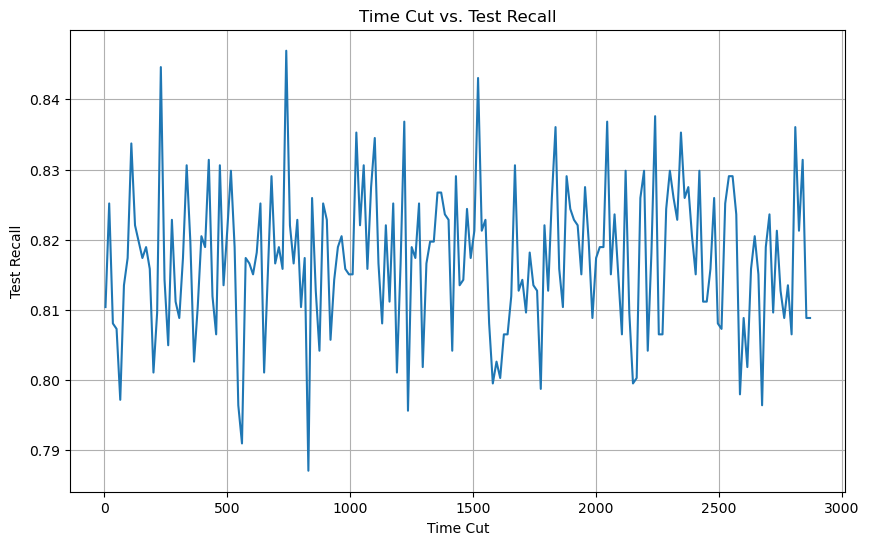

In [47]:
    # Ensure the metrics are numeric
df['metrics.time_cut'] = pd.to_numeric(df['metrics.time_cut'], errors='coerce')
df['metrics.test_recall'] = pd.to_numeric(df['metrics.test_recall'], errors='coerce')
    
# Plotting time_cut vs. test_accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x='metrics.time_cut', y='metrics.test_accuracy', data=df)
plt.title('Time Cut vs. Test Recall')
plt.xlabel('Time Cut')
plt.ylabel('Test Recall')
plt.grid(True)
plt.show()